## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [3]:
np.random.seed(0)

## Testing vectorisation

In [4]:
N = 100
M = 200
a = np.random.randn(N, M)
b = np.random.randn(N, M)
c = np.zeros((N, M))

In [11]:
%%time
for i in range(N):
  for j in range(M):
    c[i, j] = a[i, j] + b[i, j]

CPU times: total: 31.2 ms
Wall time: 21.3 ms


In [14]:
%%time
c = a + b

CPU times: total: 0 ns
Wall time: 71.3 μs


In [16]:
%%time
for i in range(N):
  for j in range(M):
    c[i, j] = np.sin(a[i, j] + 1)

CPU times: total: 46.9 ms
Wall time: 46.4 ms


## Generate data

In [17]:
%%time
c = np.sin(a + 1)

CPU times: total: 0 ns
Wall time: 570 μs


In [19]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


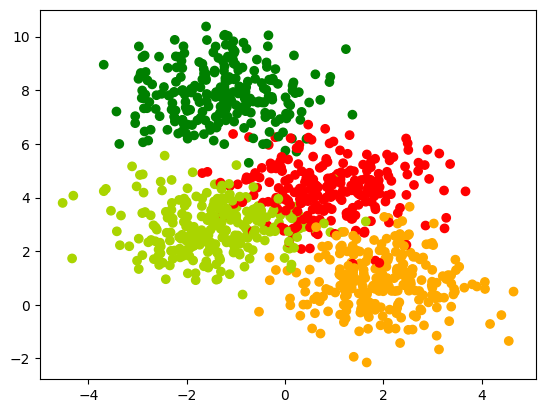

In [20]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [21]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

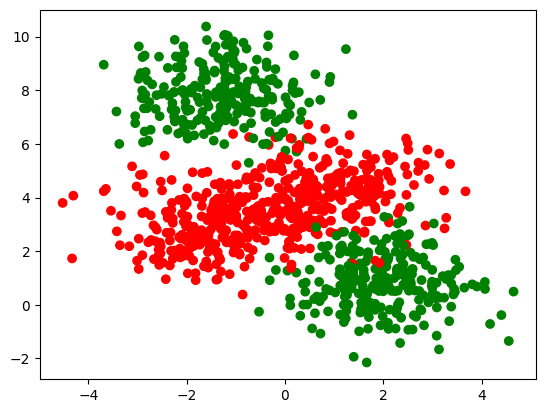

In [22]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Multi class classification

In [23]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [24]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [25]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[-1.93950036  0.73885045]
 [ 1.39468453 -0.81358502]]
[[-0.818822   -0.1027978   1.23934523  0.3642774 ]
 [-1.16663743 -0.50382808  0.11141039 -1.53470286]]


## Scalar Version

In [26]:
class FF_MultiClass_Scalar:
  
  def __init__(self, W1, W2):
    self.w1 = W1[0][0].copy()
    self.w2 = W1[1][0].copy()
    self.w3 = W1[0][1].copy()
    self.w4 = W1[1][1].copy()
    self.w5 = W2[0][0].copy()
    self.w6 = W2[1][0].copy()
    self.w7 = W2[0][1].copy()
    self.w8 = W2[1][1].copy()
    self.w9 = W2[0][2].copy()
    self.w10 = W2[1][2].copy()
    self.w11 = W2[0][3].copy()
    self.w12 = W2[1][3].copy()
    self.b1 = 0
    self.b2 = 0
    self.b3 = 0
    self.b4 = 0
    self.b5 = 0
    self.b6 = 0
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def forward_pass(self, x):
    # input layer
    self.x1, self.x2 = x
    
    # hidden layer
    self.a1 = self.w1*self.x1 + self.w2*self.x2 + self.b1
    self.h1 = self.sigmoid(self.a1)
    self.a2 = self.w3*self.x1 + self.w4*self.x2 + self.b2
    self.h2 = self.sigmoid(self.a2)
    
    # output layer
    self.a3 = self.w5*self.h1 + self.w6*self.h2 + self.b3
    self.a4 = self.w7*self.h1 + self.w8*self.h2 + self.b4
    self.a5 = self.w9*self.h1 + self.w10*self.h2 + self.b5
    self.a6 = self.w11*self.h1 + self.w12*self.h2 + self.b5
    sum_exps = np.sum([np.exp(self.a3), np.exp(self.a4), np.exp(self.a5), np.exp(self.a6)])
    self.h3 = np.exp(self.a3)/sum_exps
    self.h4 = np.exp(self.a4)/sum_exps
    self.h5 = np.exp(self.a5)/sum_exps
    self.h6 = np.exp(self.a6)/sum_exps
    
    return np.array([self.h3, self.h4, self.h5, self.h6])
  
  def grad(self, x, y):
    self.forward_pass(x)
    self.y1, self.y2, self.y3, self.y4 = y
    
    self.da3 = (self.h3-self.y1)
    self.da4 = (self.h4-self.y2)
    self.da5 = (self.h5-self.y3)
    self.da6 = (self.h6-self.y4)
    
    self.dw5 = self.da3*self.h1
    self.dw6 = self.da3*self.h2
    self.db3 = self.da3
    
    self.dw7 = self.da4*self.h1
    self.dw8 = self.da4*self.h2
    self.db4 = self.da4
    
    self.dw9 = self.da5*self.h1
    self.dw10 = self.da5*self.h2
    self.db5 = self.da5
    
    self.dw11 = self.da6*self.h1
    self.dw12 = self.da6*self.h2
    self.db6 = self.da6
    
    self.dh1 = self.da3*self.w5 + self.da4*self.w7 + self.da5*self.w9 + self.da6*self.w11
    self.dh2 = self.da3*self.w6 + self.da4*self.w8 + self.da5*self.w10 + self.da6*self.w12
    
    self.da1 = self.dh1 * self.h1*(1-self.h1)
    self.da2 = self.dh2 * self.h2*(1-self.h2)
    
    self.dw1 = self.da1*self.x1
    self.dw2 = self.da1*self.x2
    self.db1 = self.da1
    
    self.dw3 = self.da2*self.x1
    self.dw4 = self.da2*self.x2
    self.db2 = self.da2
    
  
  def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False, display_weight=False):
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw1, dw2, dw3, dw4, dw5, dw6, dw7, dw8, dw9, dw10, dw11, dw12, db1, db2, db3, db4, db5, db6  = [0]*18
      for x, y in zip(X, Y):
        self.grad(x, y)
        dw1 += self.dw1
        dw2 += self.dw2
        dw3 += self.dw3
        dw4 += self.dw4
        dw5 += self.dw5
        dw6 += self.dw6
        dw7 += self.dw7
        dw8 += self.dw8
        dw9 += self.dw9
        dw10 += self.dw10
        dw11 += self.dw11
        dw12 += self.dw12
        db1 += self.db1
        db2 += self.db2
        db3 += self.db3
        db4 += self.db4
        db2 += self.db5
        db3 += self.db6
        
      m = X.shape[0]
      self.w1 -= (learning_rate * (dw1 / m))
      self.w2 -= (learning_rate * (dw2 / m))
      self.w3 -= (learning_rate * (dw3 / m))
      self.w4 -= (learning_rate * (dw4 / m))
      self.w5 -= (learning_rate * (dw5 / m))
      self.w6 -= (learning_rate * (dw6 / m))
      self.w7 -= (learning_rate * (dw7 / m))
      self.w8 -= (learning_rate * (dw8 / m))
      self.w9 -= (learning_rate * (dw9 / m))
      self.w10 -= (learning_rate * (dw10 / m))
      self.w11 -= (learning_rate * (dw11 / m))
      self.w12 -= (learning_rate * (dw12 / m))
      self.b1 -= (learning_rate * (db1 / m))
      self.b2 -= (learning_rate * (db2 / m))
      self.b3 -= (learning_rate * (db3 / m))
      self.b4 -= (learning_rate * (db4 / m))
      self.b5 -= (learning_rate * (db5 / m))
      self.b6 -= (learning_rate * (db6 / m))
      
      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    if display_loss:
      Wt1 = [[self.w1, self.w3], [self.w2, self.w4]]
      Wt2 = [[self.w5, self.w6, self.w7, self.w8], [self.w9, self.w10, self.w11, self.w12]]
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred)

## Weight Vectorised Version

In [27]:
class FF_MultiClass_WeightVectorised:
  
  def __init__(self, W1, W2):
    self.W1 = W1.copy()
    self.W2 = W2.copy()
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,4))
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)
  
  def forward_pass(self, x):
    x = x.reshape(1, -1) # (1, 2)
    self.A1 = np.matmul(x,self.W1) + self.B1  # (1, 2) * (2, 2) -> (1, 2)
    self.H1 = self.sigmoid(self.A1) # (1, 2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2 # (1, 2) * (2, 4) -> (1, 4) 
    self.H2 = self.softmax(self.A2) # (1, 4)
    return self.H2
    
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def grad(self, x, y):
    self.forward_pass(x)
    x = x.reshape(1, -1) # (1, 2)
    y = y.reshape(1, -1) # (1, 4)
    
    self.dA2 = self.H2 - y # (1, 4) 
    
    self.dW2 = np.matmul(self.H1.T, self.dA2) # (2, 1) * (1, 4) -> (2, 4)
    self.dB2 = self.dA2 # (1, 4)
    self.dH1 = np.matmul(self.dA2, self.W2.T) # (1, 4) * (4, 2) -> (1, 2)
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1)) # -> (1, 2)
    
    self.dW1 = np.matmul(x.T, self.dA1) # (2, 1) * (1, 2) -> (2, 2)
    self.dB1 = self.dA1 # (1, 2)

  
  def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False):
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW1 = np.zeros((2,2))
      dW2 = np.zeros((2,4))
      dB1 = np.zeros((1,2))
      dB2 = np.zeros((1,4))
      for x, y in zip(X, Y):
        self.grad(x, y)
        dW1 += self.dW1
        dW2 += self.dW2
        dB1 += self.dB1
        dB2 += self.dB2  
        
      m = X.shape[0]
      self.W2 -= learning_rate * (dW2/m)
      self.B2 -= learning_rate * (dB2/m)
      self.W1 -= learning_rate * (dW1/m)
      self.B1 -= learning_rate * (dB1/m)

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
        
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()

## Input + Weight Vectorised Version

In [28]:
class FF_MultiClass_InputWeightVectorised:
  
  def __init__(self, W1, W2):
    self.W1 = W1.copy()
    self.W2 = W2.copy()
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,4))
  
  def sigmoid(self, X):
    return 1.0/(1.0 + np.exp(-X))
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X):
    self.A1 = np.matmul(X,self.W1) + self.B1 # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.sigmoid(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2 # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
    
  def grad_sigmoid(self, X):
    return X*(1-X) 
  
  def grad(self, X, Y):
    self.forward_pass(X)
    m = X.shape[0]
    
    self.dA2 = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    
    self.dW2 = np.matmul(self.H1.T, self.dA2) # (2, N) * (N, 4) -> (2, 4)
    self.dB2 = np.sum(self.dA2, axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.dH1 = np.matmul(self.dA2, self.W2.T) # (N, 4) * (4, 2) -> (N, 2)
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    
    self.dW1 = np.matmul(X.T, self.dA1) # (2, N) * (N, 2) -> (2, 2)
    self.dB1 = np.sum(self.dA1, axis=0).reshape(1, -1) # (N, 2) -> (1, 2)

      
  def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False):
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      self.grad(X, Y) # X -> (N, 2), Y -> (N, 4)
        
      m = X.shape[0]
      self.W2 -= learning_rate * (self.dW2/m)
      self.B2 -= learning_rate * (self.dB2/m)
      self.W1 -= learning_rate * (self.dW1/m)
      self.B1 -= learning_rate * (self.dB1/m)

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

C:\Users\Shaik hazarath\AppData\Local\Temp\ipykernel_233536\296666789.py:94: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

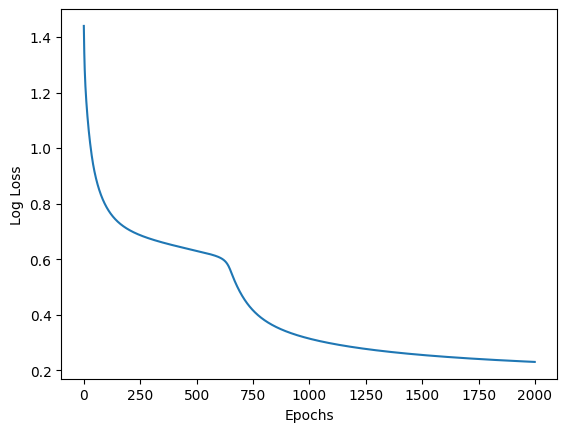

Time taken by model 1: 134.76924085617065


C:\Users\Shaik hazarath\AppData\Local\Temp\ipykernel_233536\2521095271.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

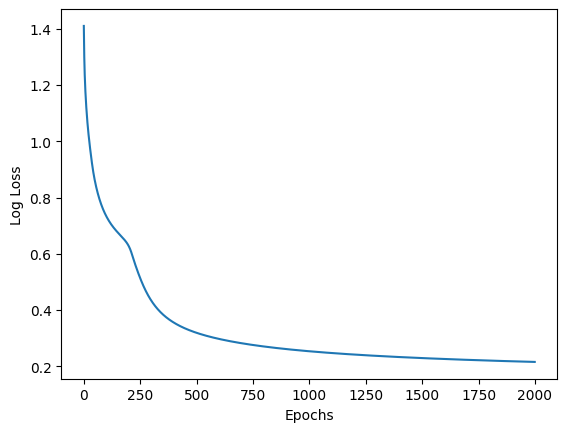

Time taken by model 2: 106.64229893684387


C:\Users\Shaik hazarath\AppData\Local\Temp\ipykernel_233536\1104452991.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

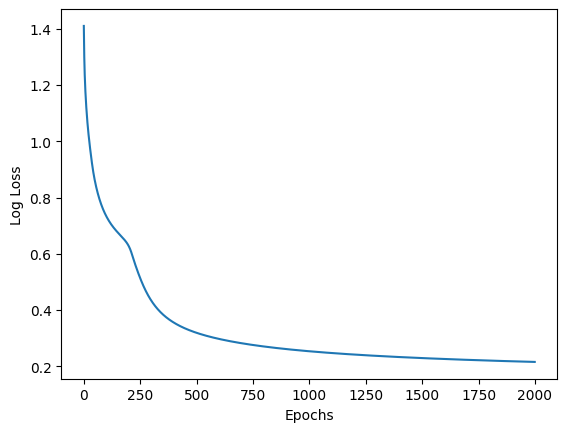

Time taken by model 3: 4.775591135025024


In [30]:
models_init = [FF_MultiClass_Scalar(W1, W2), FF_MultiClass_WeightVectorised(W1, W2),FF_MultiClass_InputWeightVectorised(W1, W2)]
models = []
for idx, model in enumerate(models_init, start=1):
  tic = time.time()
  ffsn_multi_specific = model
  ffsn_multi_specific.fit(X_train,y_OH_train,epochs=2000,learning_rate=.5,display_loss=True)
  models.append(ffsn_multi_specific)
  toc = time.time()
  print("Time taken by model {}: {}".format(idx, toc-tic))

In [31]:
for idx, model in enumerate(models, start=1):
  Y_pred_train = model.predict(X_train)
  Y_pred_train = np.argmax(Y_pred_train,1)

  Y_pred_val = model.predict(X_val)
  Y_pred_val = np.argmax(Y_pred_val,1)

  accuracy_train = accuracy_score(Y_pred_train, Y_train)
  accuracy_val = accuracy_score(Y_pred_val, Y_val)
  
  print("Model {}".format(idx))
  print("Training accuracy", round(accuracy_train, 2))
  print("Validation accuracy", round(accuracy_val, 2))

Model 1
Training accuracy 0.92
Validation accuracy 0.94
Model 2
Training accuracy 0.92
Validation accuracy 0.94
Model 3
Training accuracy 0.92
Validation accuracy 0.94


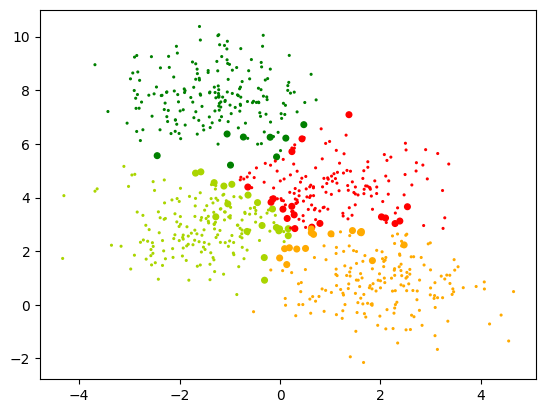

In [32]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
plt.show()